In [4]:
import pandas as pd
import numpy as np

# Load generated data
accounts_df = pd.read_csv("/Users/vimu/Documents/Data Science/00 Thesis/Github/aml-mule-risk-scoring/notebooks/data/accounts_simulated.csv")
transactions_df = pd.read_csv("/Users/vimu/Documents/Data Science/00 Thesis/Github/aml-mule-risk-scoring/notebooks/data/transactions_simulated.csv")

print(accounts_df.shape, transactions_df.shape)
accounts_df.head(), transactions_df.head()

(5000, 3) (103150, 6)


(   account_id  is_mule  account_open_day
 0           0        0                 0
 1           1        0                10
 2           2        0                24
 3           3        0                 0
 4           4        0                26,
    txn_id  timestamp_day  src_account_id  dst_account_id   amount typology
 0       0              6            1886            2708  2680.65   fan_in
 1       1             89            1087            2708  4255.66   fan_in
 2       2             35            2826            2708  2811.48   fan_in
 3       3             67            4667            2708  4707.80   fan_in
 4       4             18            3633            2708  3261.86   fan_in)

In [5]:
# Ensure all mule accounts appear
print("Mules:", accounts_df["is_mule"].sum())
print("Normals:", (accounts_df["is_mule"] == 0).sum())

# Check transaction distributions
print(transactions_df["typology"].value_counts())

Mules: 150
Normals: 4850
typology
normal         99989
fan_out         1010
fan_in           875
structuring      774
velocity         400
layering         102
Name: count, dtype: int64


In [6]:
def total_inflow(df):
    return df.groupby("dst_account_id")["amount"].sum().rename("total_inflow_amount")

def total_outflow(df):
    return df.groupby("src_account_id")["amount"].sum().rename("total_outflow_amount")

def num_unique_senders(df):
    return df.groupby("dst_account_id")["src_account_id"].nunique().rename("num_unique_senders")

def num_unique_receivers(df):
    return df.groupby("src_account_id")["dst_account_id"].nunique().rename("num_unique_receivers")

def num_incoming_txn(df):
    return df.groupby("dst_account_id")["amount"].count().rename("num_incoming_txn")

def num_outgoing_txn(df):
    return df.groupby("src_account_id")["amount"].count().rename("num_outgoing_txn")

In [7]:
def txn_velocity(df):
    # number of transactions / days active
    df["day"] = df["timestamp_day"]
    counts = df.groupby("src_account_id")["day"].count()
    span = df.groupby("src_account_id")["day"].apply(lambda x: x.max() - x.min() + 1)
    return (counts / span).rename("txn_velocity_per_day")

In [8]:
THRESHOLD = 10000  # global AML threshold

def num_txn_below_threshold(df):
    return (df[df["amount"] < THRESHOLD]
            .groupby("dst_account_id")["amount"]
            .count().rename("num_txn_below_threshold"))

def proportion_txn_below_threshold(df):
    below = df["amount"] < THRESHOLD
    return (below.groupby(df["dst_account_id"])
            .mean().rename("proportion_txn_below_threshold"))

In [9]:
def avg_txn_amount(df):
    return df.groupby("src_account_id")["amount"].mean().rename("avg_txn_amount")

def std_txn_amount(df):
    return df.groupby("src_account_id")["amount"].std().fillna(0).rename("std_txn_amount")

def zscore_outflow(df):
    series = df.groupby("src_account_id")["amount"].sum()
    z = (series - series.mean()) / series.std()
    return z.rename("zscore_outflow")

In [10]:
# Start with accounts_df index
features = pd.DataFrame({
    "account_id": accounts_df["account_id"]
})

In [11]:
# Flow
features = features.merge(total_inflow(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(total_outflow(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(num_unique_senders(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(num_unique_receivers(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(num_incoming_txn(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(num_outgoing_txn(transactions_df), how="left", left_on="account_id", right_index=True)

# Velocity
features = features.merge(txn_velocity(transactions_df), how="left", left_on="account_id", right_index=True)

# Structuring
features = features.merge(num_txn_below_threshold(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(proportion_txn_below_threshold(transactions_df), how="left", left_on="account_id", right_index=True)

# Statistical
features = features.merge(avg_txn_amount(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(std_txn_amount(transactions_df), how="left", left_on="account_id", right_index=True)
features = features.merge(zscore_outflow(transactions_df), how="left", left_on="account_id", right_index=True)

In [12]:
# Passthrough signal
features["net_flow"] = features["total_inflow_amount"].fillna(0) - features["total_outflow_amount"].fillna(0)

# Ratio
features["ratio_in_out"] = (
    features["total_inflow_amount"] /
    features["total_outflow_amount"].replace(0, np.nan)
)

In [13]:
features = features.merge(
    accounts_df[["account_id","is_mule"]],
    on="account_id",
    how="left"
)

In [14]:
features = features.fillna(0)
print(features.shape)
features.head()

(5000, 16)


,account_id,total_inflow_amount,total_outflow_amount,num_unique_senders,num_unique_receivers,num_incoming_txn,num_outgoing_txn,txn_velocity_per_day,num_txn_below_threshold,proportion_txn_below_threshold,avg_txn_amount,std_txn_amount,zscore_outflow,net_flow,ratio_in_out,is_mule
0,0,62431.88,82033.00,19,22,19,22,0.261905,18,0.947368,3728.772727,1989.944834,0.629709,-19601.12,0.761058,0
1,1,46768.85,80166.27,17,25,17,25,0.280899,17,1.000000,3206.650800,1456.849877,0.534451,-33397.42,0.583398,0
2,2,50852.16,90322.63,17,26,17,26,0.317073,17,1.000000,3473.947308,1404.153017,1.052725,-39470.47,0.563006,0
3,3,66541.04,59010.13,21,17,21,17,0.215190,21,1.000000,3471.184118,2006.422444,-0.545137,7530.91,1.127621,0
4,4,60056.69,67373.54,16,19,16,19,0.250000,16,1.000000,3545.975789,1983.661325,-0.118356,-7316.85,0.891399,0


In [25]:
features.to_csv("data/features_account_level.csv", index=False)
print("Saved to ../data/features_account_level.csv")

Saved to ../data/features_account_level.csv


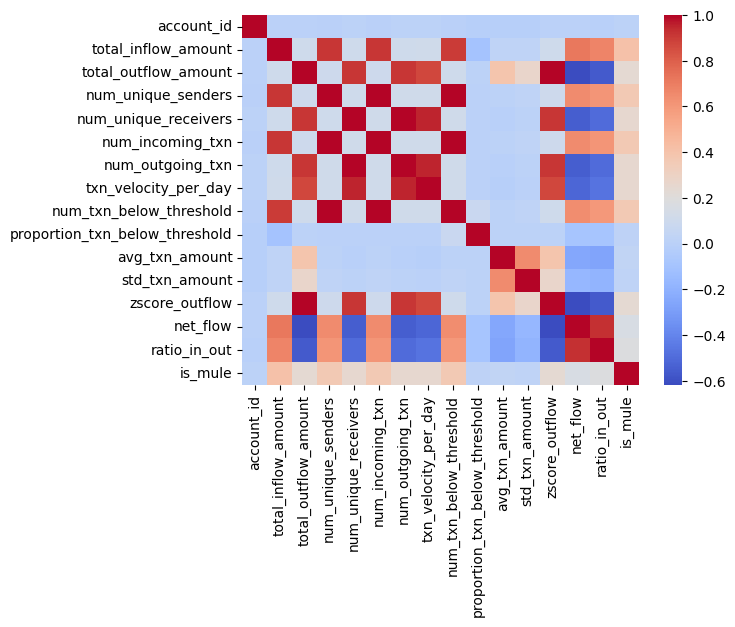

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(features.corr(), cmap="coolwarm")
plt.show()

In [18]:
features.groupby("is_mule").mean().T.head(20)

is_mule,0,1
account_id,2497.360825,2568.666667
total_inflow_amount,68100.627233,121176.528733
total_outflow_amount,68878.760103,96016.899267
num_unique_senders,20.227835,32.246667
num_unique_receivers,20.348454,28.346667
num_incoming_txn,20.266186,32.393333
num_outgoing_txn,20.388247,28.446667
txn_velocity_per_day,0.248205,0.339180
num_txn_below_threshold,20.104948,32.233333
proportion_txn_below_threshold,0.992083,0.994174


In [19]:
import pandas as pd

# --------------------------------------------------------------------
# LOAD YOUR LATEST DATA
# --------------------------------------------------------------------
acc = pd.read_csv("data/accounts_simulated.csv")
tx  = pd.read_csv("data/transactions_simulated.csv")

print("=== DATA SHAPES ===")
print("Accounts:", acc.shape)
print("Transactions:", tx.shape)


# --------------------------------------------------------------------
# 1. DUPLICATE txn_id CHECK
# --------------------------------------------------------------------
print("\n=== DUPLICATE txn_id CHECK ===")
if "txn_id" in tx.columns:
    dup = tx["txn_id"].duplicated().sum()
    print(f"Duplicate txn_id count: {dup}")
    if dup == 0:
        print("✔ PASS — All txn_id values are unique")
    else:
        print("❌ FAIL — Found duplicate transaction IDs!")
else:
    print("❌ FAIL — txn_id column missing!")


# --------------------------------------------------------------------
# 2. COLUMN CONSISTENCY CHECK
# --------------------------------------------------------------------
required_tx_cols = {"txn_id","timestamp_day","src_account_id",
                    "dst_account_id","amount","typology"}

missing_tx = required_tx_cols - set(tx.columns)
print("\n=== TRANSACTION COLUMNS CHECK ===")
print("Missing columns:", missing_tx)
if len(missing_tx) == 0:
    print("✔ PASS — All required transaction columns exist")
else:
    print("❌ FAIL — Missing critical transaction fields")


required_acc_cols = {"account_id","is_mule","account_open_day"}
missing_acc = required_acc_cols - set(acc.columns)
print("\n=== ACCOUNT COLUMNS CHECK ===")
print("Missing columns:", missing_acc)
if len(missing_acc) == 0:
    print("✔ PASS — All required account columns exist")
else:
    print("❌ FAIL — Missing critical account fields")


# --------------------------------------------------------------------
# 3. NO topology IN ACCOUNTS
# --------------------------------------------------------------------
print("\n=== ACCOUNTS TOPOLOGY CHECK ===")
if "typology_type" in acc.columns:
    print("❌ FAIL — 'typology_type' still present in accounts_df")
else:
    print("✔ PASS — No topology in accounts table")


# --------------------------------------------------------------------
# 4. TYPOLGY DISTRIBUTION CHECK (transaction level)
# --------------------------------------------------------------------
print("\n=== TYPOLOGY DISTRIBUTION ===")
if "typology" in tx.columns:
    print(tx["typology"].value_counts())
else:
    print("❌ FAIL — typology column missing in tx!")


# --------------------------------------------------------------------
# 5. LINKAGE CHECK — all src/dst exist in accounts table
# --------------------------------------------------------------------
tx_ids = set(tx["src_account_id"]) | set(tx["dst_account_id"])
acc_ids = set(acc["account_id"])

missing_accounts = tx_ids - acc_ids

print("\n=== REFERENTIAL INTEGRITY CHECK ===")
print("Missing account references:", len(missing_accounts))
if len(missing_accounts) == 0:
    print("✔ PASS — all transaction account IDs exist in accounts_df")
else:
    print("❌ FAIL — transactions reference missing accounts!")

=== DATA SHAPES ===
Accounts: (5000, 3)
Transactions: (103150, 6)

=== DUPLICATE txn_id CHECK ===
Duplicate txn_id count: 0
✔ PASS — All txn_id values are unique

=== TRANSACTION COLUMNS CHECK ===
Missing columns: set()
✔ PASS — All required transaction columns exist

=== ACCOUNT COLUMNS CHECK ===
Missing columns: set()
✔ PASS — All required account columns exist

=== ACCOUNTS TOPOLOGY CHECK ===
✔ PASS — No topology in accounts table

=== TYPOLOGY DISTRIBUTION ===
typology
normal         99989
fan_out         1010
fan_in           875
structuring      774
velocity         400
layering         102
Name: count, dtype: int64

=== REFERENTIAL INTEGRITY CHECK ===
Missing account references: 0
✔ PASS — all transaction account IDs exist in accounts_df


In [21]:
import pandas as pd
import numpy as np

# --------------------------------------------------------------------
# LOAD DATA
# --------------------------------------------------------------------
df = pd.read_csv("data/features_account_level.csv")

print("=== SHAPE ===")
print(df.shape)

print("\n=== HEAD ===")
print(df.head(3))


# --------------------------------------------------------------------
# 1. CHECK REQUIRED COLUMNS
# --------------------------------------------------------------------
required_cols = [
    "account_id", "is_mule", "total_inflow_amount", "total_outflow_amount",
    "num_unique_senders", "num_unique_receivers", "num_incoming_txn",
    "num_outgoing_txn", "txn_velocity_per_day", "num_txn_below_threshold",
    "proportion_txn_below_threshold", "avg_txn_amount", "std_txn_amount",
    "zscore_outflow", "net_flow", "ratio_in_out"
]

missing = set(required_cols) - set(df.columns)
print("\n=== MISSING FEATURE COLUMNS ===")
print(missing)
if len(missing) == 0:
    print("✔ PASS — all required features exist")
else:
    print("❌ FAIL — missing features")


# --------------------------------------------------------------------
# 2. PRIMARY KEY CHECK
# --------------------------------------------------------------------
print("\n=== ACCOUNT ID UNIQUENESS ===")
dup = df["account_id"].duplicated().sum()
print("Duplicate account_id:", dup)
if dup == 0:
    print("✔ PASS — account_id uniquely identifies feature rows")
else:
    print("❌ FAIL — duplicate account feature rows!")


# --------------------------------------------------------------------
# 3. NULL VALUE CHECK
# --------------------------------------------------------------------
print("\n=== NULLS ===")
null_counts = df.isna().sum()
print(null_counts[null_counts > 0])
if df.isna().sum().sum() == 0:
    print("✔ PASS — no missing values")
else:
    print("⚠ WARNING — missing values detected!")


# --------------------------------------------------------------------
# 4. VALUE RANGE CHECK (sanity)
# --------------------------------------------------------------------
print("\n=== BASIC STATS (quick checks) ===")
print(df.describe().T[["mean","std","min","max"]].head(10))


# --------------------------------------------------------------------
# 5. CLASS BALANCE CHECK
# --------------------------------------------------------------------
print("\n=== CLASS BALANCE ===")
print(df["is_mule"].value_counts())
print("Mule % =", round(df["is_mule"].mean()*100, 2))


# --------------------------------------------------------------------
# 6. FEATURE SCALE CONSISTENCY
# - Velocity should be small (< 1)
# - Proportion < 1
# - Ratios generally near 1
# --------------------------------------------------------------------
print("\n=== RANGE CHECKS ===")
print("Velocity max:", df["txn_velocity_per_day"].max())
print("Prop_below max:", df["proportion_txn_below_threshold"].max())
print("Ratio_in_out max:", df["ratio_in_out"].max())

if (
    df["txn_velocity_per_day"].max() < 10 and
    df["proportion_txn_below_threshold"].max() <= 1 and
    df["ratio_in_out"].max() < 10
):
    print("✔ PASS — feature ranges look realistic")
else:
    print("⚠ WARNING — some feature scales suspicious")


# --------------------------------------------------------------------
# 7. CORRELATION WITH TARGET (quick insight)
# --------------------------------------------------------------------
print("\n=== TOP CORRELATIONS TO is_mule ===")
corr = df.corr(numeric_only=True)["is_mule"].sort_values(ascending=False)
print(corr.head(10))
print("\n=== NEGATIVE Correlations ===")
print(corr.tail(10))

=== SHAPE ===
(5000, 16)

=== HEAD ===
   account_id  total_inflow_amount  total_outflow_amount  num_unique_senders  \
0           0             62431.88              82033.00                  19   
1           1             46768.85              80166.27                  17   
2           2             50852.16              90322.63                  17   

   num_unique_receivers  num_incoming_txn  num_outgoing_txn  \
0                    22                19                22   
1                    25                17                25   
2                    26                17                26   

   txn_velocity_per_day  num_txn_below_threshold  \
0              0.261905                       18   
1              0.280899                       17   
2              0.317073                       17   

   proportion_txn_below_threshold  avg_txn_amount  std_txn_amount  \
0                        0.947368     3728.772727     1989.944834   
1                        1.000000     32

In [22]:
import numpy as np

features["log_total_inflow"]  = np.log1p(features["total_inflow_amount"])
features["log_total_outflow"] = np.log1p(features["total_outflow_amount"])

In [23]:
cols = [
    "account_id",
    "is_mule",
    "total_inflow_amount", "total_outflow_amount",
    "log_total_inflow", "log_total_outflow",
    "num_unique_senders", "num_unique_receivers",
    "num_incoming_txn", "num_outgoing_txn",
    "txn_velocity_per_day",
    "num_txn_below_threshold",
    "proportion_txn_below_threshold",
    "avg_txn_amount", "std_txn_amount",
    "zscore_outflow", "net_flow", "ratio_in_out",
]

features = features[cols]

In [24]:
print(features[["log_total_inflow","log_total_outflow"]].describe())
print(features[["total_inflow_amount","log_total_inflow"]].corr())

       log_total_inflow  log_total_outflow
count       5000.000000        5000.000000
mean          11.110354          11.115125
std            0.284061           0.271651
min            9.607049           9.539022
25%           10.940955          10.947256
50%           11.120572          11.131059
75%           11.289944          11.297447
max           12.595473          12.594044
                     total_inflow_amount  log_total_inflow
total_inflow_amount             1.000000          0.944416
log_total_inflow                0.944416          1.000000


In [26]:
features.describe() 

,account_id,is_mule,total_inflow_amount,total_outflow_amount,log_total_inflow,log_total_outflow,num_unique_senders,num_unique_receivers,num_incoming_txn,num_outgoing_txn,txn_velocity_per_day,num_txn_below_threshold,proportion_txn_below_threshold,avg_txn_amount,std_txn_amount,zscore_outflow,net_flow,ratio_in_out
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000
mean,2499.500000,0.030000,69692.904278,69692.904278,11.110354,11.115125,20.588400,20.588400,20.630000,20.630000,0.250934,20.468800,0.992145,3379.165237,1695.458753,-9.521273e-17,2.561137e-13,1.071656
std,1443.520003,0.170604,22106.567873,19596.503952,0.284061,0.271651,5.646606,5.402039,5.679573,5.418798,0.062118,5.663518,0.020189,397.418679,391.500863,1.000000e+00,2.795623e+04,0.449419
min,0.000000,0.000000,14868.220000,13890.360000,9.607049,9.539022,5.000000,6.000000,5.000000,6.000000,0.085366,5.000000,0.812500,2134.282941,530.773576,-2.847577e+00,-2.009874e+05,0.182911
25%,1249.750000,0.000000,56440.225000,56797.002500,10.940955,10.947256,17.000000,17.000000,17.000000,17.000000,0.211765,17.000000,1.000000,3110.895955,1415.343506,-6.580716e-01,-1.681801e+04,0.781818
50%,2499.500000,0.000000,67545.500000,68257.595000,11.120572,11.131059,20.000000,20.000000,20.000000,20.000000,0.246833,20.000000,1.000000,3352.341749,1676.942551,-7.324313e-02,-7.487700e+02,0.989552
75%,3749.250000,0.000000,80011.942500,80614.587500,11.289944,11.297447,23.000000,23.000000,23.000000,23.000000,0.283951,23.000000,1.000000,3626.932054,1966.763679,5.573281e-01,1.570626e+04,1.266529
max,4999.000000,1.000000,295218.000000,294796.520000,12.595473,12.594044,89.000000,97.000000,90.000000,97.000000,1.077778,90.000000,1.000000,5011.248000,3266.990330,1.148693e+01,2.458502e+05,5.979968


In [27]:
features[["log_total_inflow","log_total_outflow","is_mule"]].corr()

,log_total_inflow,log_total_outflow,is_mule
log_total_inflow,1.000000,0.062180,0.289222
log_total_outflow,0.062180,1.000000,0.163175
is_mule,0.289222,0.163175,1.000000
